# Real Data Example - 01
In this example we will average a monthly data into a weekly time scale, 
as well as yearly averages.

## Importing Some Data
We are going to use the "RASM" data set that you could load using `xarray`. Within that data
set, we will work with `Tair` variable which is air temperature.

In [21]:
import xarray as xr
monthly_air_temperature = xr.tutorial.load_dataset("rasm").Tair
print("Air Temperature Attributes:")
for k, v in monthly_air_temperature.attrs.items():
    print("%15s: %s" % (k, str(v)))

Air Temperature Attributes:
          units: C
      long_name: Surface air temperature
 type_preferred: double
       time_rep: instantaneous


Lets now check the time axis:

In [22]:
time_axis = monthly_air_temperature["time"]
nTime = time_axis.size
print("size/length of time axis: ", nTime)
print("First Three Time Values: \n", time_axis.values[:3])
print("Last Three Time Values: \n", time_axis.values[-3:])

size/length of time axis:  36
First Three Time Values: 
 [cftime.DatetimeNoLeap(1980-09-16 12:00:00)
 cftime.DatetimeNoLeap(1980-10-17 00:00:00)
 cftime.DatetimeNoLeap(1980-11-16 12:00:00)]
Last Three Time Values: 
 [cftime.DatetimeNoLeap(1983-06-16 12:00:00)
 cftime.DatetimeNoLeap(1983-07-17 00:00:00)
 cftime.DatetimeNoLeap(1983-08-17 00:00:00)]


as you can see this data set contains monthly temperature, starting from Septermber, 1980,
going for 36 months (3 years), and ending on August, 1983. Let's plot the time series for 
one location:

<BarContainer object of 36 artists>

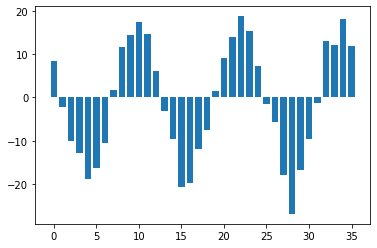

In [23]:
import numpy as np
from matplotlib import pyplot as plt
#matplotlib inline

iy = 20
ix = 200
plt.bar(np.arange(nTime), monthly_air_temperature[:, iy, ix])

## Calculating Weekly Average using `AxisUtilities`
As you have learned in orevious notebooks, in order to perform the remapping we need to
perform the follow four steps:

0. Create source axis object,
1. Create destination axis object,
2. Create a remapping object, and finally
3. Perform the remapping

*NOTE* if you haven't read through the tutorial notebooks yet, perhaps now it's a good
time to have a look at them.

### Creating source axis
As seen above, the source data covers 36 months of data starting with September of 1980 and
ending on August of 1983.
You can use one of the available utilities to easily create the source axis:

In [24]:
from axisutilities import MonthlyTimeAxis
monthly_axis = MonthlyTimeAxis(
    start_year=1980,
    start_month=9,
    end_year=1983,
    end_month=8
)
print("source axis: \n", monthly_axis)

source axis: 
 <timeaxis.TimeAxis>

  > nelem:
	36
  > lower_bound:
	[336614400000000 ... 428544000000000]
  > upper_bound:
	[339206400000000 ... 431222400000000]
  > data_ticks:
	[337910400000000 ... 429883200000000]
  > fraction:
	[0.5 ... 0.5]
  > binding:
	middle


### Creating destination axis
Lets create a destination axis, with each element representing one week rather than a month.
Our destination axis starts on September 1st, 1980, and has 156 week/elements in it:

In [25]:
from datetime import date
from axisutilities import WeeklyTimeAxis
weekly_axis = WeeklyTimeAxis(
    start_date=date(1980, 9, 1),
    n_interval=156
)

print("Destination Axis: \n", weekly_axis)

Destination Axis: 
 <timeaxis.TimeAxis>

  > nelem:
	156
  > lower_bound:
	[336614400000000 ... 430358400000000]
  > upper_bound:
	[337219200000000 ... 430963200000000]
  > data_ticks:
	[336916800000000 ... 430660800000000]
  > fraction:
	[0.5 ... 0.5]
  > binding:
	middle


### Creating a remapper
The remapper could be created as follows:

In [26]:
from axisutilities import AxisRemapper
monthly_to_weekly_remapper = AxisRemapper(
    from_axis=monthly_axis, 
    to_axis=weekly_axis,
    assure_no_bound_mismatch=False
)

Note that since the source and destination matrix do not cover exactly the same period 
(156 week is a feww days shorter than 3 years covered in our source data), we
need to inform the remapper that we are aware of this mismatch and we do still want to
perform this conversion or remapping. That's the reason for passing `assure_no_bound_mismatch`
parameter and setting it to `False`. If the source and destination axis cover the exact
period, there is no need to pass that paramaeter.

### Calculating the weekly average
Now that we have created the remapper we can easily remap the data from monthly axis to
weekly axis:

In [27]:
weekly_air_temperature = monthly_to_weekly_remapper.average(monthly_air_temperature)

/Users/mabouali/NCAR/GitHub/coderepocenter/AxisUtilities/axisutilities/axisremapper.py:273: RuntimeWarning: divide by zero encountered in reciprocal
  inverse_sum_effective_weights = np.reciprocal(weights * non_nan_mask)
/Users/mabouali/NCAR/GitHub/coderepocenter/AxisUtilities/axisutilities/axisremapper.py:276: RuntimeWarning: invalid value encountered in multiply
  np.multiply(weights * from_data_copy, inverse_sum_effective_weights),


Let's plot the time series for the same location as before:

<BarContainer object of 156 artists>

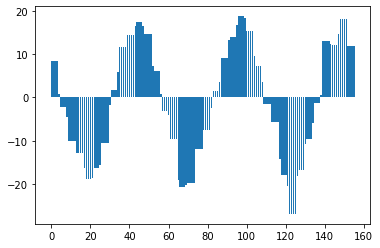

In [20]:
plt.bar(np.arange(weekly_axis.nelem), weekly_air_temperature[:, iy, ix])

## Calculating Yearly averages
The same four steps needs to be followed to calculate yearly averages.

### Creating source axis
since the data has not changed, we could use the same source axis as before. So there is
no need to recreate it here.

### Creating Yearly axis:
We need to create a 4 year axis

In [ ]:
from axisutilities import Y

In [7]:
ds["time"] = pd.date_range(start="1980-09-16 12:00:00", freq='1M', periods=36)
ds

NameError: name 'pd' is not defined

In [ ]:
ds_resampled = ds.resample(time='1W').mean()
ds_resampled

In [ ]:
from_axis = MonthlyTimeAxisBuilder(start_year=1980, start_month=9, end_year=1983, end_month=8).build()
to_axis = WeeklyTimeAxisBuilder(start_date=date(1980, 9, 30), n_interval=153).build()

In [ ]:
tc = AxisConverter(from_axis=from_axis, to_axis=to_axis)
tc

In [ ]:
Tair_remapped_data = tc.average(ds)
Tair_remapped = xr.DataArray(Tair_remapped_data, dims=('time', 'y', 'x'), coords=ds_resampled.coords)
Tair_remapped

In [ ]:
Tair_remapped.dtype, ds_resampled.dtype

In [ ]:
Tair_remapped.shape, ds_resampled.shape

In [ ]:
np.testing.assert_allclose(Tair_remapped, ds_resampled)

In [ ]:
Tair_remapped[0]

In [ ]:
ds_resampled.data[0]

In [ ]:
np.testing.assert_allclose(Tair_remapped[0], ds_resampled.data[0])

In [ ]:
ds_resampled.isel(time=0).plot()

In [ ]:
Tair_remapped.isel(time=0).plot()

In [ ]:
ds_resampled.min(), ds_resampled.max(), ds_resampled.mean(), ds_resampled.median()

In [ ]:
Tair_remapped.min(), Tair_remapped.max(), Tair_remapped.mean(), Tair_remapped.median()